In [1]:
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dist

from IPython.display import clear_output
import matplotlib.pyplot as plt


use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# Replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done, t):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done, t)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, t = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done, t
    
    def __len__(self):
        return len(self.buffer)

# Value Network (Critic)
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

# Soft Q Network (Critic)
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + 1, hidden_size) # num_inputs + action
        self.linear2 = nn.Linear(hidden_size, 1)
        self.linear3 = nn.Linear(num_inputs + 1, hidden_size) # num_inputs + action
        self.linear4 = nn.Linear(hidden_size, 1)
        
        self.linear2.weight.data.uniform_(-init_w, init_w)
        self.linear2.bias.data.uniform_(-init_w, init_w)
        
        self.linear4.weight.data.uniform_(-init_w, init_w)
        self.linear4.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        
        x1 = F.relu(self.linear1(x))
        x1 = self.linear2(x1)
        
        x2 = F.relu(self.linear3(x))
        x2 = self.linear4(x2)

        return x1, x2

# PolicyNetwork (Actor)
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3): #log_std_max=2
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size) # nn.Linear(hidden_size, num_actions)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        self.softplus = nn.Softplus()
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
#         x = F.relu(self.linear2(x))
        probs = F.softmax(self.linear3(x), dim=-1)
        
        return probs # policy
    
    def sample(self, state):
        probs = self.forward(state)
        action = dist.Categorical(probs).sample().unsqueeze(1)
        
        mask = torch.zeros_like(probs).scatter_(1, action, 1).to(torch.uint8) # one-hot
        sampled_prob = torch.masked_select(probs, mask).unsqueeze(1)
        
        log_prob = torch.log(sampled_prob)
        
        return probs, action.to(torch.float32), log_prob
        
    def evaluate(self, state):
        probs = self.forward(state)
        action = torch.argmax(probs, dim=1)
        return action
    

def soft_q_update(batch_size, gamma=0.99, alpha=0.25, soft_tau= 5e-3): # alpha :temperature for entropy

    state, action, reward, next_state, done, t = replay_buffer.sample(batch_size)

#     state      = torch.Tensor(state).unsqueeze(1).to(device)
    state      = torch.Tensor(state).to(device)
    next_state = torch.Tensor(next_state).to(device)
    action     = torch.Tensor(action).unsqueeze(1).to(device)
    reward     = torch.Tensor(reward).unsqueeze(1).to(device)
    done       = torch.Tensor(np.float32(done)).unsqueeze(1).to(device)
    t          = torch.Tensor(t).unsqueeze(1).to(device)
    
    '''
    with torch.no_grad():
        next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
        qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
        min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
        
        next_q_value = reward_batch + mask_batch * self.gamma * (min_qf_next_target)
    qf1, qf2 = self.critic(state_batch, action_batch)  # Two Q-functions to mitigate positive bias in the policy improvement step
    qf1_loss = F.mse_loss(qf1, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
    qf2_loss = F.mse_loss(qf2, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]

    pi, log_pi, _ = self.policy.sample(state_batch)

    qf1_pi, qf2_pi = self.critic(state_batch, pi)
    min_qf_pi = torch.min(qf1_pi, qf2_pi)

    policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean() # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]
    '''
    # calculate loss for v
    # Jv = E_{s_t}[0.5*(V(s_t) - E_{a_t}[Q_min(s_t, a_t) - log(policy(a_t|s_t))])^2]
    # where s_t in D and a_t ~ policy
    
    
    with torch.no_grad():
        next_prob, next_action, next_log_prob = policy_net.sample(next_state)
        q_1_next_target, q_2_next_target = target_q_net(next_state, next_action)
        min_q_next_target = torch.min(q_1_next_target, q_2_next_target) - alpha * next_log_prob
        next_q_value = reward + (1-done) * gamma * (min_q_next_target)

    expected_q_1, expected_q_2 = q_net(state, action)
    q_1_loss = F.mse_loss(expected_q_1, next_q_value)
    q_2_loss = F.mse_loss(expected_q_2, next_q_value)
    
    probs, new_action, log_prob = policy_net.sample(state)
    
    q1_new, q2_new = q_net(state, new_action)
    min_q_new = torch.min(q1_new, q2_new)

    policy_loss = ((alpha * log_prob) - min_q_new).mean() # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]
    
    q_net_optimizer.zero_grad()
    q_1_loss.backward()
    q_net_optimizer.step()
    
    q_net_optimizer.zero_grad()
    q_2_loss.backward()
    q_net_optimizer.step()
    
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    # update target network
    for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)
    
    return [q_1_loss.item(), q_2_loss.item(), policy_loss.item()]

In [21]:
replay_buffer_size = 100000 # 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

def getaction(policy_net, state, mode): # fcn which returns categorical action 
    inventory = state[1]
    
    state = torch.Tensor(state).to(device)
    probs = policy_net(state) # q : categorical action probability

    if inventory > 0.0:
        # If there is a buying share in inventory, SELL or HOLD (additional buying is prohibited)
        if probs[SELL] > probs[HOLD]:
            return SELL
        else:
            return HOLD

    elif inventory < 0.0:
        # If there is a selling share in inventory, BUY or HOLD (additional selling is prohibited)
        if probs[BUY] > probs[HOLD]:
            return BUY
        else:
            return HOLD
    else:
        # If there are no share in inventory, BUY, SELL, or HOLD

        if mode == 'train':
            m = dist.Categorical(probs)
            action = m.sample()
            return int(action)
        
        
        elif mode == 'eval':
            action = torch.argmax(probs, dim=-1)
            return action.item()
        
        
def scenario(policy_net, data):
    
    policy_net.train()
    
    # initial setting
    spread = data['dPrice'][0]
    inventory = 0

    start = np.random.randint(low=1, high=1000) # arbitrary start point for iterative training
    step = np.random.randint(low=100, high=500) # arbitrary step, because delta t(Tick) is very small

    for t in range(start, len(data), step):
        
        spread = data['dPrice'][t]
        state = [spread, inventory]
        action = getaction(policy_net, state, mode='train')
    
        done = False
        reward = 0.
        
        if inventory > 0.0:
            if action == SELL:
                inventory = 0
                # Originally selling can be done in ask price
                # however, we assume that we can sell at mid-price in order to check the effect of SOBI starategy 
                sellprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                reward += sellprice - buyprice
                done = True
                
        elif inventory < 0.0:
            if action == BUY:
                inventory = 0
                buyprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                reward += sellprice - buyprice
                done = True

        else:
            if action == BUY:
                inventory += 1
                buyprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                
            elif action == SELL:
                inventory -= 1
                sellprice = (data['bidprc'][t] + data['askprc'][t]) / 2
            
        action = float(action)
        
        if t >= len(data)-step : # when time over with inventory 0
            next_state = [data['dPrice'].iloc[-1], inventory]
            reward = 0.
            action = HOLD
            done = True
            
        else : 
            next_state = [data['dPrice'][t+step], inventory]

        
        replay_buffer.push(state, action, reward, next_state, done, t)

        
        if done == True: # one episode end
            return reward
        

## Training

In [5]:
action_dim = 3
state_dim = 2
hidden_dim = 16

# v_net        = ValueNetwork(state_dim, hidden_dim).to(device)
# target_v_net = ValueNetwork(state_dim, hidden_dim).to(device)

# for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
#     target_param.data.copy_(param.data)

# soft_q_1_net = SoftQNetwork(state_dim, hidden_dim).to(device)
# soft_q_2_net = SoftQNetwork(state_dim,  hidden_dim).to(device)
q_net = SoftQNetwork(state_dim, hidden_dim).to(device)
target_q_net = SoftQNetwork(state_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
    target_param.data.copy_(param.data)

# v_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()


losses = {"q_1_loss": [], "q_2_loss": [],"policy_loss": []}
batch_size  = 256

replay_buffer_size = 100000 # 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

q_net_optimizer = optim.Adam(q_net.parameters(), lr=3e-4)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=3e-4)

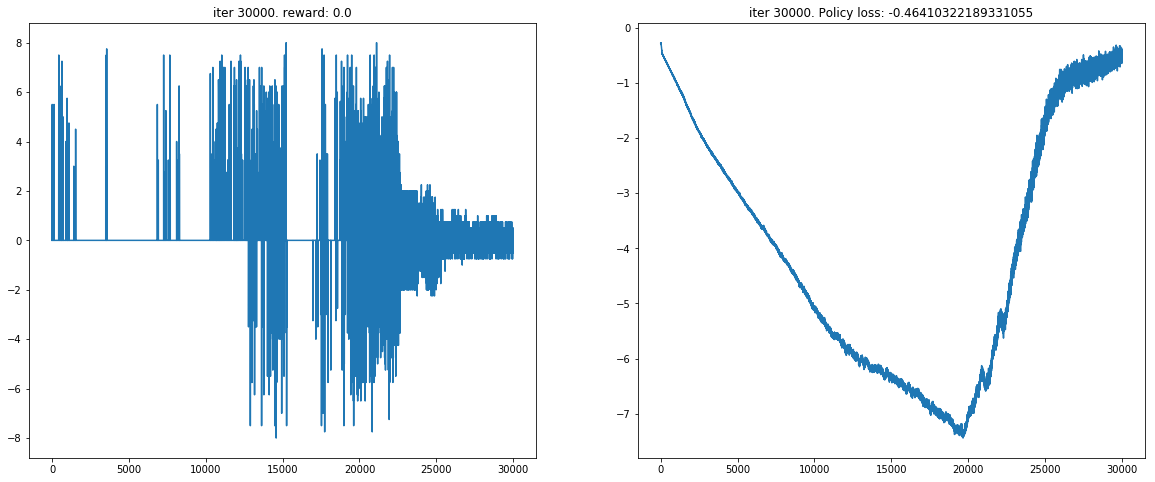

KeyboardInterrupt: 

In [6]:
data = pd.read_csv('SOBI.csv')

BUY = 0
SELL = 1
HOLD = 2
ACTIONS = [BUY, SELL, HOLD]

inventory = 0
buyprice = 0
sellprice = 0

max_iteration = 50000


rewards=[]
iteration = 0
reward = 0

while iteration < max_iteration:
    
    episode_reward = scenario(policy_net, data) # generating & saving one scenario and return reward

    # Training
    if len(replay_buffer) > batch_size: # batch_size
        loss_list = soft_q_update(batch_size)
        for i, (key, value) in enumerate(losses.items()):
            losses[key].append(loss_list[i])

#     reward += episode_reward
    rewards.append(episode_reward)

    if iteration % 500 == 0:
        plot(iteration, losses, rewards)
    
    iteration += 1
    
#     if iteration % 500 == 0:
#         torch.save()

남은작업
1. 버퍼 크기, alpha 크기 바꿔보기
2. iteration 별로 animation 만들어서 경과가 어떤지 관찰하기
3. 유의미하면 쓰고 아니면 그냥 괜찮은 정적인 누적 수익 찾아서 올리기
4. readme 작업
5. 쪽지보내기

### alpha = 0.3

In [17]:
action_dim = 3
state_dim = 2
hidden_dim = 256

# v_net        = ValueNetwork(state_dim, hidden_dim).to(device)
# target_v_net = ValueNetwork(state_dim, hidden_dim).to(device)

# for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
#     target_param.data.copy_(param.data)

# soft_q_1_net = SoftQNetwork(state_dim, hidden_dim).to(device)
# soft_q_2_net = SoftQNetwork(state_dim,  hidden_dim).to(device)
q_net = SoftQNetwork(state_dim, hidden_dim).to(device)
target_q_net = SoftQNetwork(state_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
    target_param.data.copy_(param.data)

# v_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()


losses = {"q_1_loss": [], "q_2_loss": [],"policy_loss": []}
batch_size  = 256

replay_buffer_size = 10000 # 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

q_net_optimizer = optim.Adam(q_net.parameters(), lr=3e-4)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=3e-4)

In [ ]:
def plot(iteration, losses, rewards):
    clear_output(True)
    
    plt.figure(figsize=(20,8))
    
    ax0 = plt.subplot(221)
    plt.title('iter %s. reward: %s' % (iteration, rewards[-1]))
    plt.plot(rewards)
    
    ax1 = plt.subplot(222)
    plt.title('iter %s. Policy loss: %s' % (iteration, losses['policy_loss'][-1]))
    plt.plot(losses['policy_loss'])
    
    ax2 = plt.subplot(212)
    plt.title('iter %s. Q1 loss: %s' % (iteration, losses['q_1_loss'][-1]))
    plt.plot(losses['q_1_loss'])
    

    plt.show()
    
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 20})

ax0 = plt.subplot(221)
ax0.set_title('iter %s. reward: %s' % (iteration, rewards[-1]))
# plt.plot(rewards)

ax1 = plt.subplot(222)
ax1.set_title('iter %s. Policy loss: %s' % (iteration, losses['policy_loss'][-1]))
# plt.plot(losses['policy_loss'])

ax2 = plt.subplot(212)
ax2.set_title('iter %s. Accumulated profit: %s' % (iteration, losses['q_1_loss'][-1]))
plt.plot(losses['q_1_loss'])


ax.set_xlim(( 0.7, 1.4))
ax.set_ylim((-0.1, 0.4))

ax.set_xlabel('Strike')
ax.set_ylabel('P&L')

ax.set_title("Hedging Option", fontdict={'fontsize':40})

line0, = ax0.plot([], [])
line1, = ax1.plot([], [])
line2, = ax2.plot([], [])

ax2.fill_between(np.arange(len(total_profits[0])) ,pd.Series(total_profits[0]).fillna(method='ffill').values,
                  alpha=0.2, color='indigo')

plt.plot(x,np.maximum(x-K,0), color='k', label='Call payoff') # payoff graph

def init():
    line0.set_data([],[])
    line1.set_data([],[])
    line2.set_data([],[])
    
    return line0, line1, line2

def animate(i):
    x0 = S_list[:i]
    y0 = rewards[:i]
    line0.set_data(x, y)
    
    x1 = S_list[:i]
    y1 = losses['policy_loss'][:i]
    line1.set_data(x, y)
    
    x2 = np.arange(len(total_profits[0]))
    y2 = total_profits[0]:
    line2.set_data(x, y)
    
    return line0, line1, line2

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=50, blit=True)

#anim.save('1. Hedging Option with Replicating Portfolio_.gif', writer='imagemagick', fps=30, dpi=10)
anim.save('4. High Frequency Trading with RL.gif', writer='imagemagick')

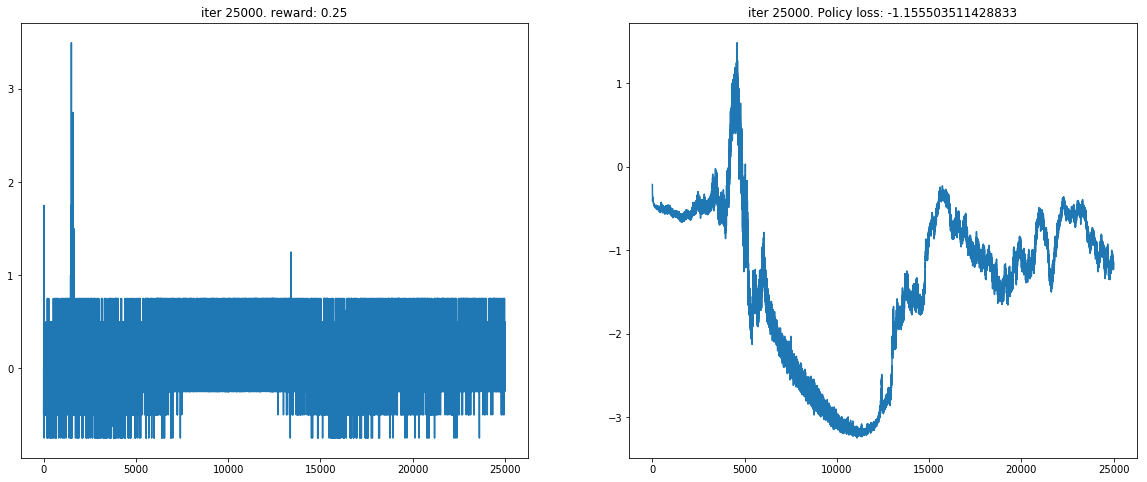

In [18]:
data = pd.read_csv('SOBI.csv')

BUY = 0
SELL = 1
HOLD = 2
ACTIONS = [BUY, SELL, HOLD]

inventory = 0
buyprice = 0
sellprice = 0

max_iteration = 25000
rewards=[]
iteration = 0
reward = 0

while iteration < max_iteration:
    
    episode_reward = scenario(policy_net, data) # generating & saving one scenario and return reward

    # Training
    if len(replay_buffer) > batch_size: # batch_size
        loss_list = soft_q_update(batch_size, alpha=0.25)
        for i, (key, value) in enumerate(losses.items()):
            losses[key].append(loss_list[i])

#     reward += episode_reward
    rewards.append(episode_reward)
    iteration += 1
    
    if iteration % 500 == 0:
        plot(iteration, losses, rewards)
    
    
    
#     if iteration % 500 == 0:
#         torch.save()

## Trading simulation

In [33]:
def simulation(policy_net, n):

    policy_net.eval()
    
    start = np.random.randint(low=1, high=1000) # arbitrary start point for iterative training
    step = np.random.randint(low=100, high=500) # arbitrary step, because delta t(Tick) is very small
    
    total_profits = []
    for i in range(n):
        inventory = 0
        buyprice = 0
        sellprice = 0
        reward = 0.
        
        profits=[]
        #for t in range(start, len(data), step):
        for t in range(0, len(data)):
            spread = data['dPrice'][t]
            state = [spread, inventory]
            action = getaction(policy_net, state, mode='eval')

            if inventory > 0.0:
                if action == SELL:
                    inventory = 0
                    # Originally selling can be done in ask price
                    # however, we assume that we can sell at mid-price in order to check the effect of SOBI starategy 
                    sellprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                    reward += sellprice - buyprice
                    profits.append(reward)

            elif inventory < 0.0:
                if action == BUY:
                    inventory = 0
                    buyprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                    reward += sellprice - buyprice
                    profits.append(reward)

            else:
                if action == BUY:
                    inventory += 1
                    buyprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                    profits.append(None)

                elif action == SELL:
                    inventory -= 1
                    sellprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                    profits.append(None)
        
        total_profits.append(profits)
        print('Simulation %.f is completed' % (i+1))
        
    return total_profits


In [167]:
len(data)

183934

In [34]:
total_profits = simulation(policy_net, n=1)

Simulation 1 is completed


In [28]:
len(total_profits)

1

## Result

In [38]:
len(total_profits[0])

183934

In [ ]:
plt.plot(total_profits, alpha=0.3, color='r', marker='o', markersize = 7)
# plt.fill_between(x, y, color='indigo')
plt.title('Accumulated Profit')
plt.show()

In [46]:
pd.Series(total_profits[0]).fillna(method='ffill').values

array([   nan,  0.   ,  0.   , ..., 20.375, 20.375, 20.375])

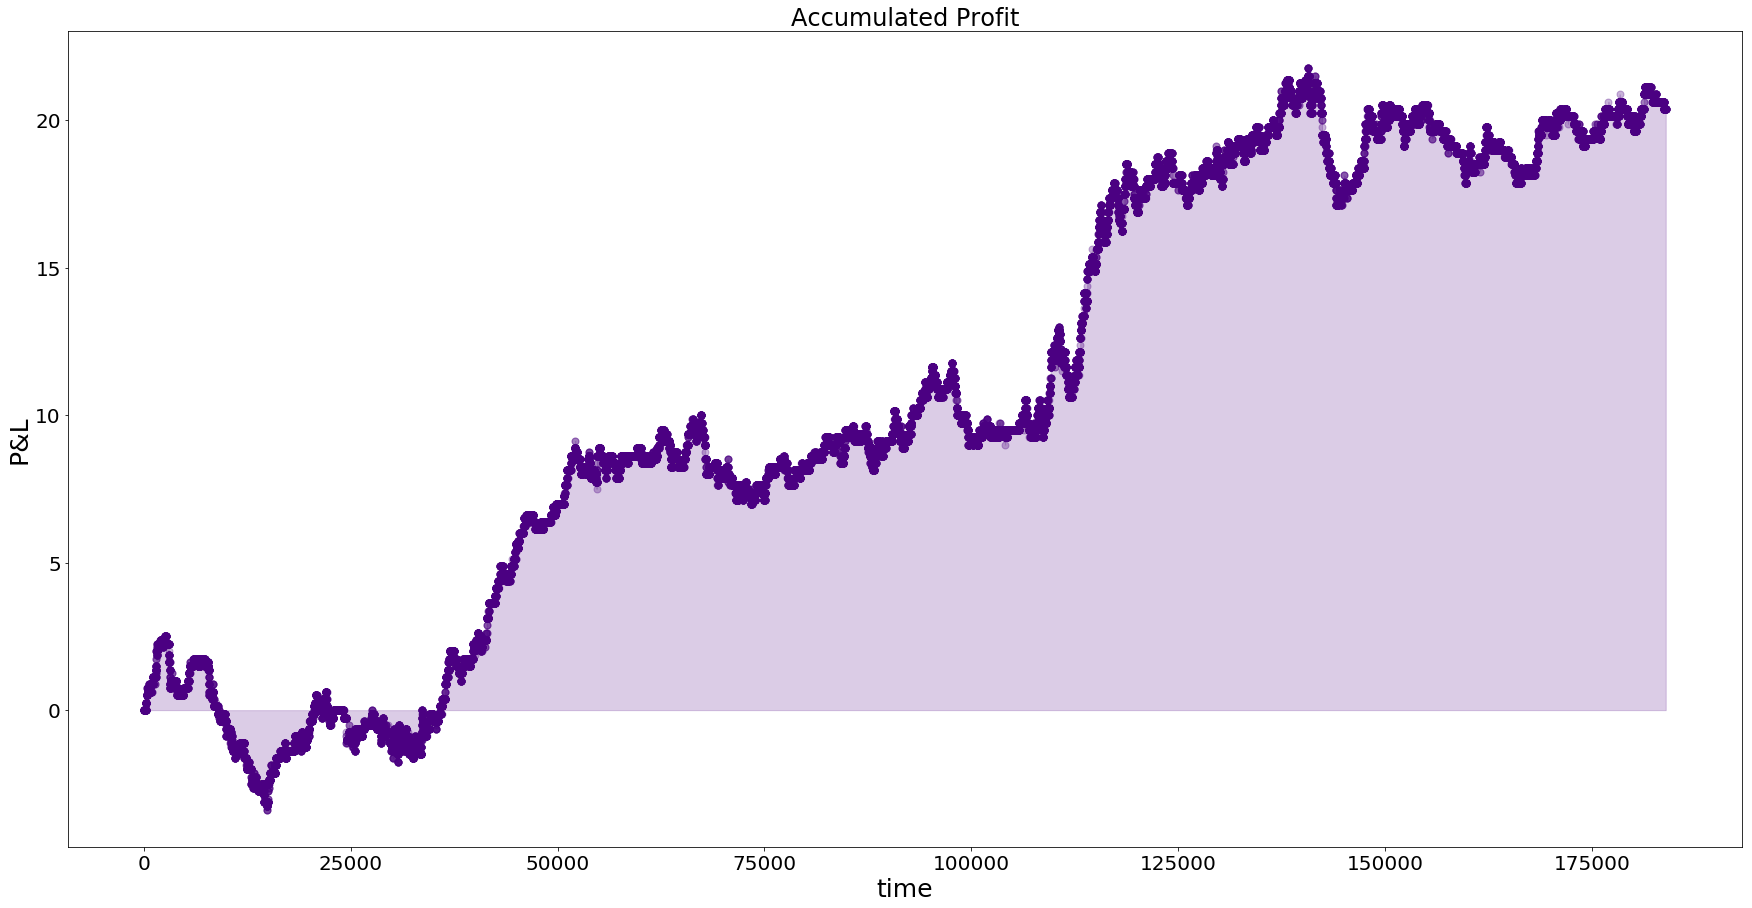

In [49]:
# 누적 profit을 확인한다
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 20})
plt.rc('axes', labelsize = 25)
plt.rc('figure', titlesize = 30)

plt.xlabel('time')
plt.ylabel('P&L')
plt.plot(np.arange(len(total_profits[0])) ,total_profits[0], alpha=0.3, color='indigo', marker='o', markersize = 7)

plt.fill_between(np.arange(len(total_profits[0])) ,pd.Series(total_profits[0]).fillna(method='ffill').values,
                  alpha=0.2, color='indigo')
plt.title('Accumulated Profit')
plt.show()

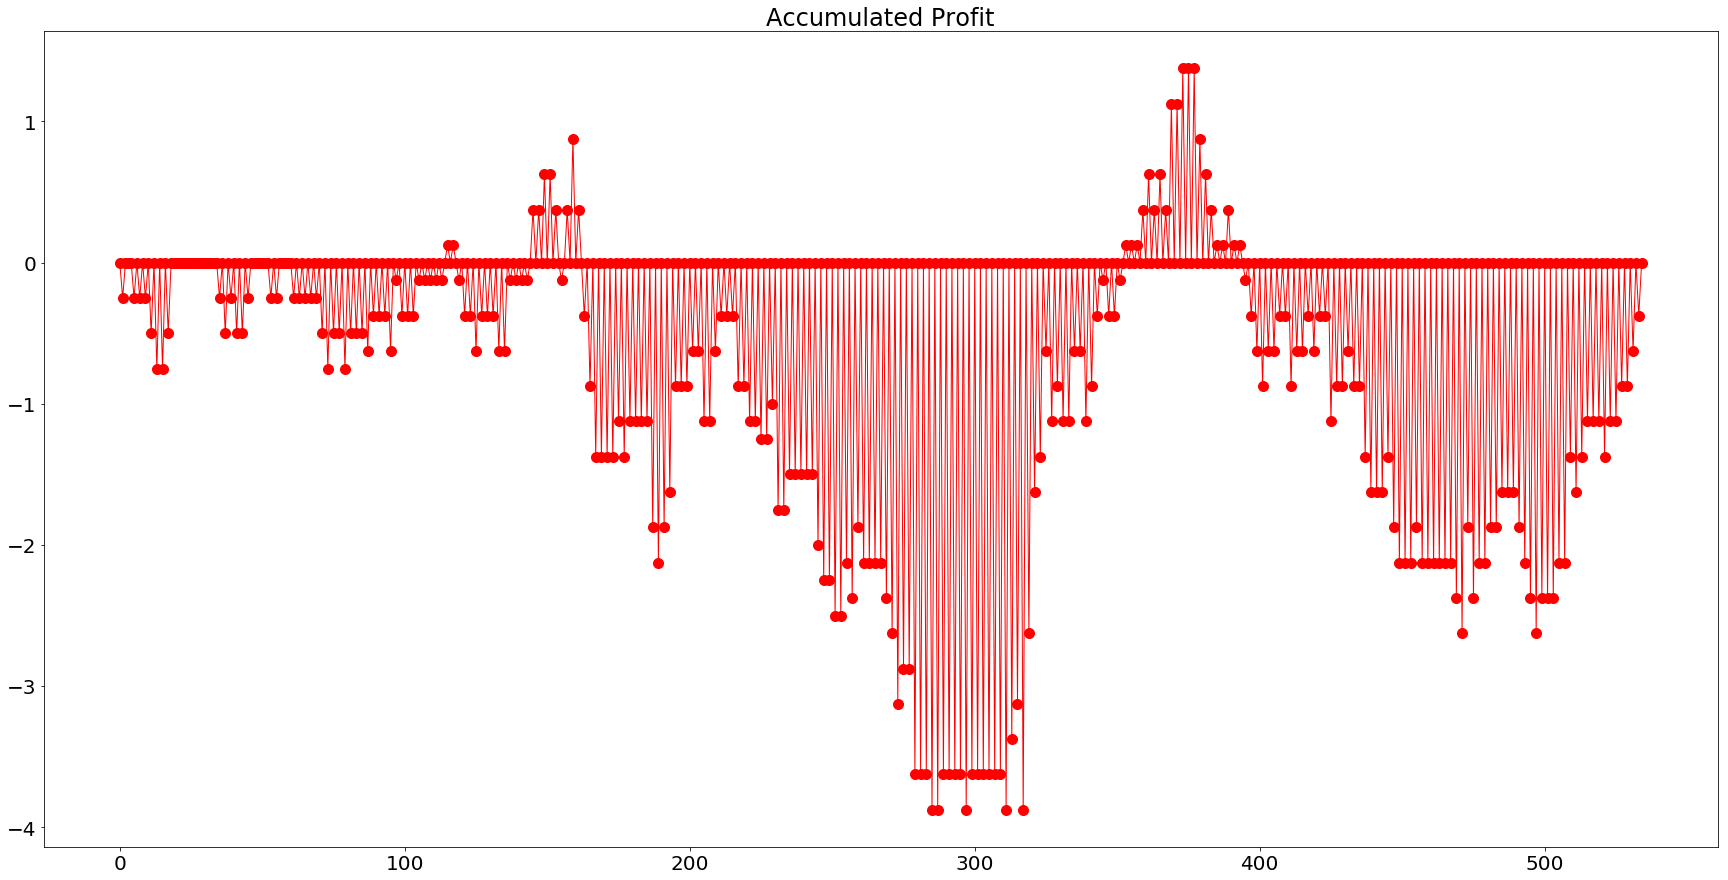

In [145]:
# 누적 profit을 확인한다
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 20})
plt.rc('axes', labelsize = 25)
plt.rc('figure', titlesize = 30)

plt.plot(total_profits[0], linewidth=1, color='r', marker='o', markersize = 10)
plt.title('Accumulated Profit')
plt.show()

In [23]:
total_profits

[[0.75,
  1.0,
  0.75,
  0.75,
  0.75,
  0.25,
  0.5,
  0.75,
  0.75,
  0.75,
  1.0,
  0.75,
  1.0,
  0.75,
  0.5,
  0.75,
  0.75,
  0.25,
  0.5,
  0.25,
  0.75,
  0.75,
  1.0,
  1.0,
  0.75,
  0.75,
  0.5,
  0.25,
  0.75,
  -0.75,
  -0.75,
  -1.25,
  -1.5,
  -1.5,
  -1.0,
  -0.75,
  -0.75,
  -0.5,
  -0.25,
  -0.25,
  0.0,
  0.5,
  0.75,
  0.5,
  1.0,
  1.0,
  0.5,
  0.75,
  1.75,
  1.5,
  0.75,
  0.75,
  1.0,
  1.25,
  1.25,
  1.25,
  1.25,
  0.75,
  1.25,
  1.5,
  1.5,
  1.75,
  2.0,
  1.0,
  1.25,
  1.0,
  1.0,
  0.75,
  1.0,
  0.25,
  0.5,
  0.5,
  0.25,
  0.5,
  1.0,
  0.75,
  1.0,
  1.25,
  1.75,
  1.5,
  1.0,
  1.0,
  0.75,
  0.25,
  0.5,
  1.0,
  1.0,
  1.25,
  1.25,
  1.0,
  0.75,
  0.75,
  0.25,
  0.0,
  1.5,
  1.5,
  0.75,
  1.25,
  1.25,
  1.5,
  1.0,
  1.0,
  0.75,
  0.75,
  0.75,
  0.75,
  0.75,
  0.75,
  0.5,
  1.0,
  2.0,
  2.0,
  2.5,
  1.75,
  1.75,
  1.75,
  1.75,
  2.0,
  2.5,
  3.25,
  3.0,
  3.5,
  4.5,
  4.5,
  4.5,
  4.25,
  4.5,
  4.5,
  5.0,
  5.0,
  5.25,
  5

In [ ]:
W[0] = call_price(S[0], K, 84/252, r, sigma)
x=np.linspace(0.7, 1.4, 100)

plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()

ax.set_xlim(( 0.7, 1.4))
ax.set_ylim((-0.1, 0.4))

ax.set_xlabel('Strike')
ax.set_ylabel('P&L')

ax.set_title("Hedging Option", fontdict={'fontsize':40})

line, = ax.plot([], [], 'ro', alpha=0.5, markersize=20,label='Replicated portfolio')
plt.plot(x,np.maximum(x-K,0), color='k', label='Call payoff') # payoff graph

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = S_list[:i]
    y = W_list[:i]
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=50, blit=True)

#anim.save('1. Hedging Option with Replicating Portfolio_.gif', writer='imagemagick', fps=30, dpi=10)
anim.save('1. Hedging Option with Replicating Portfolio_.gif', writer='imagemagick')

S_list=[]
W_list=[]
for i in range(150):
    for t in range(0, total_date): # 84 days after
        Z = np.random.randn()
        S[t+1] = S[t]*np.exp((mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
        ttm = (84-t)/252 # time to maturity 84/252
        delta[t+1] = call_delta(S[t+1], K, ttm, r, sigma)
        C[t+1] = call_price(S[t+1], K, ttm, r, sigma)
        
        dZ = np.sqrt(1*dt)*Z # Brownian Motion
        dW = r*W[t]*dt + delta[t]*S[t]*((mu-r)*dt + sigma * dZ) # dynamics of Replicated Portfolio
        
        W[t+1] = W[t] + dW # rough dynamic equation
    
    S_list.append(S[-1][0])
    W_list.append(W[-1][0])

plt.show()
plt.legend()